In [1]:
import numpy as np

import os
os.chdir('../') # Go to the parent folder
from support_functions import *
os.chdir('MNIST')

Using TensorFlow backend.


## Read Datasets
### Define File Names

In [2]:
data_path = 'data/input_data/'
imgs_train_fname = 'imgs_train.npy'
imgs_test_fname = 'imgs_test.npy'
labels_train_fname = 'labels_train.npy'
labels_test_fname = 'labels_test.npy'

### Load all saved datasets

In [3]:
imgs_train = np.load(data_path + imgs_train_fname) # images in the training set, with shape: 60000 * 32 * 32
imgs_test = np.load(data_path + imgs_test_fname) # images in the testing set, with shape: 10000 * 32 * 32

labels_train = np.load(data_path + labels_train_fname) # labels in the training set, a vector with length 60000
labels_test = np.load(data_path + labels_test_fname) # labels in the test set, a vector with length 10000

### Define Anomaly
Both the training set and the testing set contain the images of digits 0-9, and all the digits have almost equivalent number of images (please refer to the "Exploratory data analysis" file in the data folder for the histogram). 

**Here we define the images of the digit 0 as anomaly, and the images of other digits as normal. **

In [4]:
anomaly_digit = 2 # Define 0 as our target digit that we categorize as anomaly

# Mark the labels of the target digit as anomaly (1), and others as normal (0)
labels_anomaly_train = label_anomaly(labels_train, anomaly_digit) 
labels_anomaly_test = label_anomaly(labels_test, anomaly_digit) 

#### Plot the sample images with labels

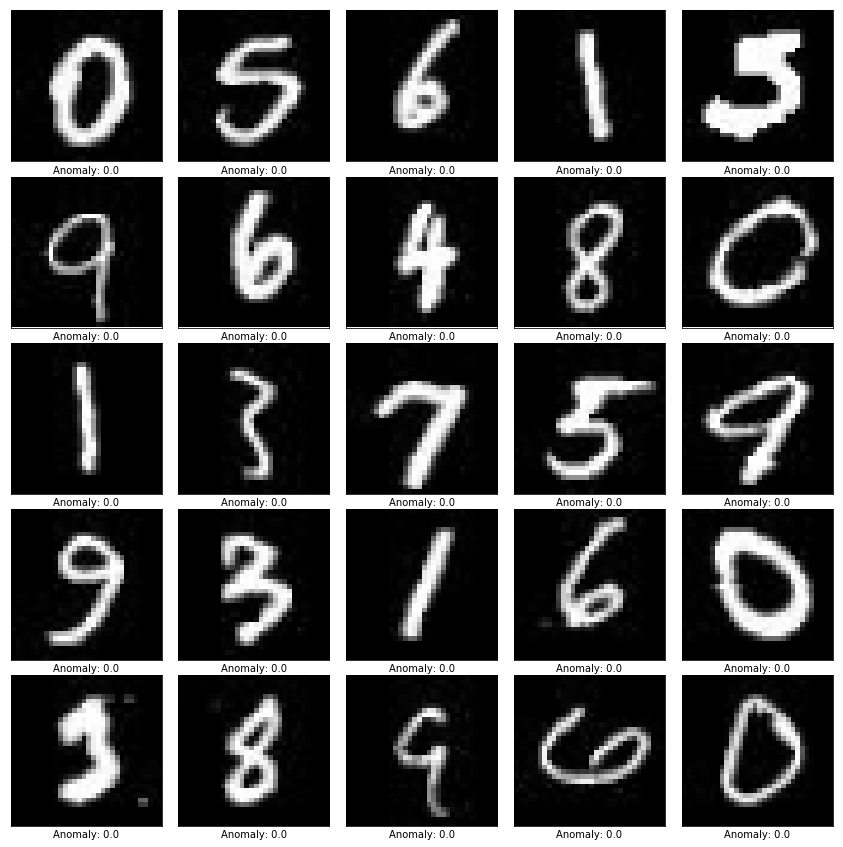

In [5]:
plot_images(imgs_train,labels_anomaly_train)

## PCA Method
### Apply PCA and Plot Eigenfaces

In [6]:
# Define the number of Principal Components to keep from the image
n_components  = 200

#### Transform the image sets into 2-D Matrices

In [7]:
# Record the dimensions of the image sets
img_height = imgs_train.shape[1]
img_width = imgs_train.shape[2]
img_dimension = img_height*img_width
len_train = len(imgs_train)
len_test = len(imgs_test)

# reshape to a 2-D Matrix
imgs_train = imgs_train.reshape(len_train,-1) # reshape to 60000 * 1024
imgs_test = imgs_test.reshape(len_test,-1) # reshape to 10000 * 1024

#### Compute and Sort Eigenvectors with Only the Normal Data

In [8]:
# Select only the Normal Image Dataset
imgs_train_normal = imgs_train[labels_anomaly_train == 0] # matrix: x*n, where x is the remaining number of imgs

# Take a Mean-Shift - With only the Normal Data
# imgs_train_normal_shifted: matrix of size x*n
# component_mean_normal: vector of size n
imgs_train_normal_shifted, component_mean_normal = mean_shift(imgs_train_normal)

# Compute the Covariance Matrix of the Image Matrix - With only the Normal Data
# cov_matrix should be the size of n*n, where n is the number of dimensions in the dataset
cov_matrix = np.cov(imgs_train_normal_shifted,rowvar=0) # important to add rowvar to specify the axis

# Compute the eigen value and eigen vectors
# eigen value: length of n
# eigen vectors: matrix of size n*n
eigen_value, eigen_vector = np.linalg.eig(cov_matrix)

# Sort the eigenvectors by decreasing eigenvalues
# First make a list of (eigenvalue, eigenvector) tuples 
eig_pairs = [(np.abs(eigen_value[i]), eigen_vector[:,i]) for i in range(len(eigen_value))] 

# Sort the (eigenvalue, eigenvector) tuples from high to low 
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Convert the sorted eigen vector list to matrix form
eigen_vector_sorted = np.zeros((img_dimension,img_dimension))
for i in range(0,len(eig_pairs)):
    # Put eigen vectors in column
    eigen_vector_sorted[:,i] = eig_pairs[i][1]
    
# Cut the sorted eigenvectors by columns to get the transformational matrix for PCA
pca_matrix = eigen_vector_sorted[:,:n_components]

#### Plot the eigenfaces

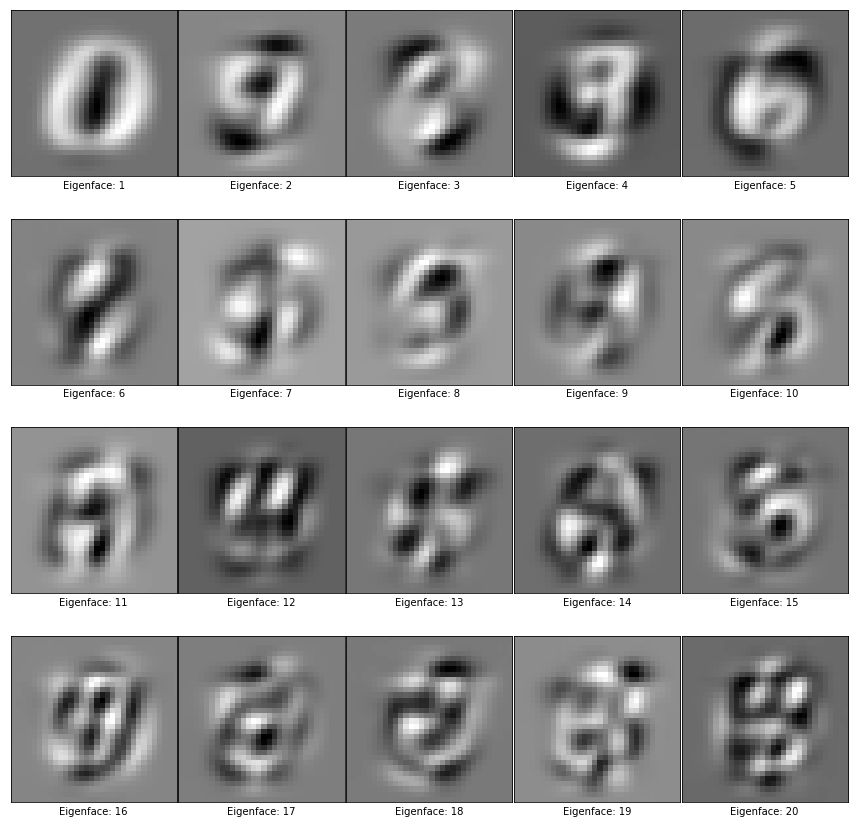

In [9]:
# Visualize the eigenfaces with the pca matrix
plot_eigenfaces(pca_matrix, img_height, img_width)

### Reconstruct the Face Images after PCA
With only the Normal Data

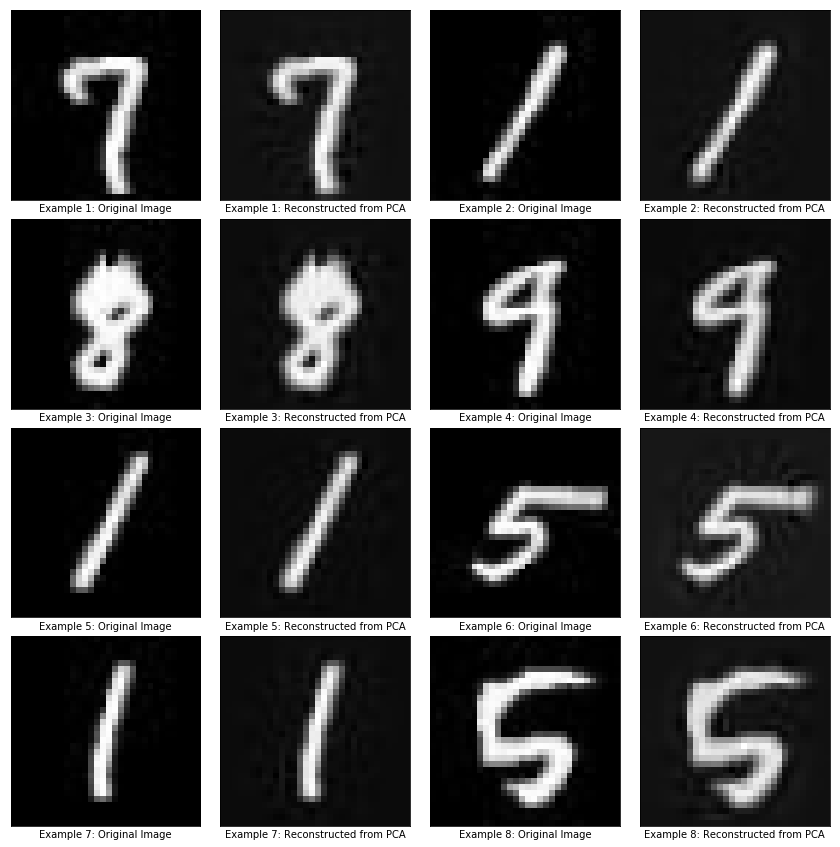

In [10]:
# Compute the transformed image
# Shape of imgs_matrix: m * n
# Shape of pca_matrix: n * k
# Shape of the transformed image matrix: m * k
img_pca_tranf_normal = imgs_train_normal_shifted.dot(pca_matrix)

# Reconstruct through PCA Matrix and Mean Vector
# Shape of the reconstructed face image matrix: m * n
img_matrix_reconst_normal = img_pca_tranf_normal.dot(pca_matrix.T) + component_mean_normal

# Plot the original images and their reconstructed version for comparison
plot_compare_after_reconst(img_matrix_reconst_normal,imgs_train_normal,img_height,img_width)

### Anomaly Detection with Reconstruction Error on PCA

#### Apply PCA Reconstruction to both Training and Testing Set

In [11]:
imgs_train_reconst = pca_reconst(imgs_train,pca_matrix) # Reconstruct the Training set
imgs_test_reconst = pca_reconst(imgs_test,pca_matrix) # Reconstruct the Testing set

#### Find the Optimal Threshold based on the Training dataset

The higher the reconstruction error, the more likely the point will be an anomaly


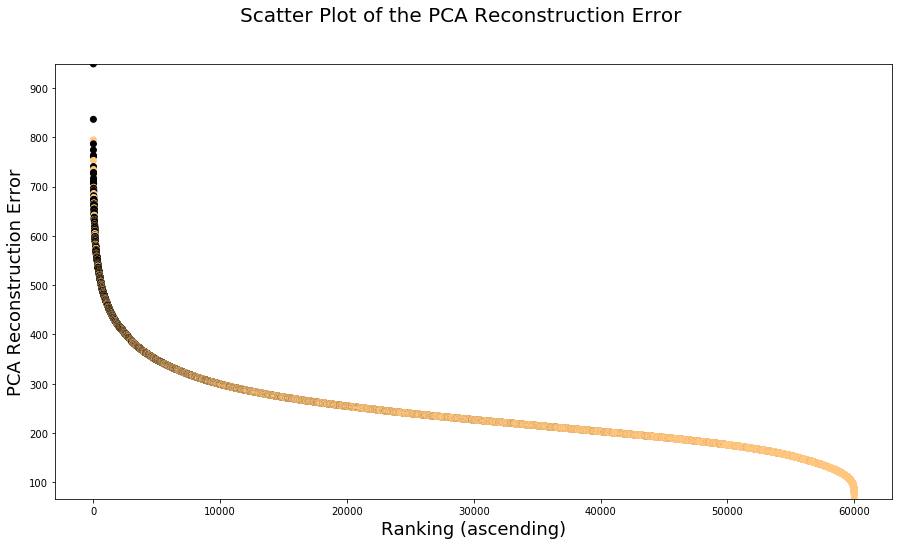

In [12]:
# Find the euclidean distance between the reconstructed dataset and the original ()
dist_train = find_euclidean_distance(imgs_train_reconst,imgs_train)
print("The higher the reconstruction error, the more likely the point will be an anomaly")
plot_scatter_with_labels(dist_train,labels_anomaly_train,'PCA Reconstruction Error')

In [13]:
k = 50 # Define the k parameter for the precision at k
threshold_error = select_threshold_distance(dist_train, labels_anomaly_train,k,to_print = True)

Precision: 42.4%
Recall: 57.6%
F-score: 48.9%
Precision@50: 72.0%


#### Evaluate the Detector with the Testing Dataset

In [14]:
# Find the euclidean distance between the reconstructed dataset and the original ()
dist_test = find_euclidean_distance(imgs_test_reconst,imgs_test)

# Sort the Images and Labels based on the Probability
rank_test = np.argsort(-dist_test) # Sort from the Largest to the Smallest
dist_test_ranked = dist_test[rank_test] # Sort the distance
# Rank Labels
labels_test_ranked = labels_anomaly_test[rank_test]
# Give Predictions
preds = np.zeros(labels_anomaly_test.shape) # Initialization
preds[dist_test_ranked > threshold_error] = 1

# Evaluate the Detector with Testing Data
eval_with_test(preds, labels_test_ranked, k)

Precision: 43.5%
Recall: 53.5%
F-score: 46.6%
Precision@50: 72.0%
